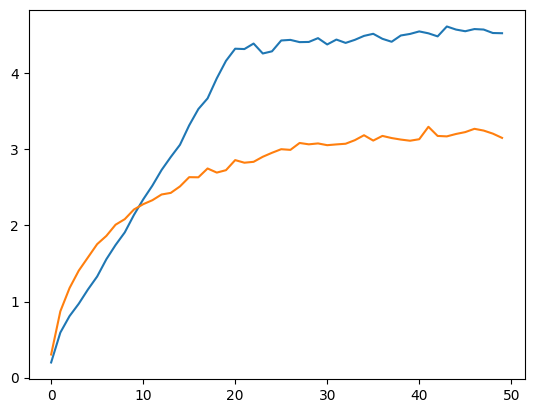

In [189]:
import numpy as np
import matplotlib.pyplot as plt


class Model:
    def __init__(self, num_states, num_branches) -> None:
        self.num_states = num_states
        self.num_branches = num_branches
        self.trans = np.random.randint(num_states, size=(num_states, 2, num_branches))
        self.rewards = np.random.randn(num_states, 2, num_branches)

    def sample(self, state, action):
        if np.random.random() < 0.1:
            return 0, self.num_states
        return self.rewards[state, action], self.trans[state, action, np.random.choice(self.num_branches)]
        

    
def expected_update(model, num_travels, epsilon = 0.1):
    v0s = np.zeros(num_travels)
    qs = np.zeros((model.num_states, 2))
    trans_prob = 0.9 / model.num_branches
    states = np.arange(model.num_states)
    for n in range(num_travels):
        qs_new = np.zeros((model.num_states, 2))
        for b in range(model.num_branches):
            s_primes = model.trans[states, :, b] 
            qs_new += (model.rewards[states] + qs.max(1,keepdims=True))*trans_prob            
        qs = qs_new
        v0s[n] = qs[0].max() * 0.9 + qs[0].mean() * 0.1
    return v0s

def epsilon_greedy(qs, epsilon):
    if np.random.random() < epsilon:
        return np.random.choice(len(qs))
    else:
        return qs.argmax()

def calc_start_state_value(model, qs, epsilon = 0.1):
    v0 = 0
    num_avg = 200
    for n in range(num_avg):
        state = 0
        while state < model.num_states:
            action = epsilon_greedy(qs[state], epsilon)
            reward, next_state = model.sample(state, action)
            v0 += reward
            state = next_state
    return v0/num_avg


def uniform_sample(model, num_updates, stat_freq, epsilon = 0.1, alpha = 0.1):
    num_stat = (num_updates + stat_freq - 1) // stat_freq
    v0s = np.zeros(num_stat)
    qs = np.zeros((model.num_states, 2))
    for n in range(num_updates):
        sa = n % (model.num_states*2)
        state = sa//2#np.random.choice(model.num_states)
        action = sa%2 #np.random.choice(2)
        #state = n % model.num_states
        #action = epsilon_greedy(qs[state], epsilon)
        reward, next_state = model.sample(state, action)
        qs_prime = (qs[next_state].max() if next_state < model.num_states else 0)
        #if state == 0 and action==0:
        #    print(state, action, reward, next_state, qs[state, action], reward + qs_prime)
        qs[state, action] += (reward + qs_prime - qs[state, action]) * alpha
        if n % stat_freq == 0:
            v0s[n//stat_freq] = calc_start_state_value(model, qs)
    #print(qs[0])
    return v0s



def trajectory_sample(model, num_updates, stat_freq, epsilon = 0.1, alpha = 0.1):
    num_stat = (num_updates + stat_freq - 1) // stat_freq
    v0s = np.zeros(num_stat)
    qs = np.zeros((model.num_states, 2))
    state = 0
    for n in range(num_updates):
        action = epsilon_greedy(qs[state], epsilon)
        reward, next_state = model.sample(state, action)
        if next_state < model.num_states:
            qs[state, action] += (reward + qs[next_state].max()-qs[state, action])*alpha
            state = next_state
        else:
            qs[state, action] = (reward - qs[state, action])*alpha
            state = 0
        if n % stat_freq == 0:
            v0s[n//stat_freq] = calc_start_state_value(model, qs)
    return v0s

num_travels = 5
num_runs = 100
num_states = 1000
num_updates = num_travels * num_states
stat_freq = 100
num_stat = (num_updates + stat_freq - 1) // stat_freq

avg_v0s_u = np.zeros(num_stat)
avg_v0s_t = np.zeros(num_stat)
for r in range(num_runs):
    #v0s = expected_update(model, num_travels)
    model = Model(num_states,3)
    avg_v0s_u += uniform_sample(model, num_updates, stat_freq)#trajectory_sample
    avg_v0s_t += trajectory_sample(model, num_updates, stat_freq)#
avg_v0s_u /= num_runs
avg_v0s_t /= num_runs

plt.plot(range(num_stat), avg_v0s_u)
plt.plot(range(num_stat), avg_v0s_t)



In [200]:
def test(branch):
    rewards = np.random.randn(10, 2, branch)
    mean = rewards.mean(axis=2)
    max = mean.max(axis=1)
    return max.sum()

s1 = 0.
s3 = 0.
s10 = 0.
num = 10000
for n in range(num):
    s1 += test(1)
    s3 += test(3)
    s10 += test(10)

s1/num, s3/num, s10/num

(5.666392582389692, 3.2559936485656573, 1.7835814706610003)